In [21]:
from competition_toolkit.dataloader import download_dataset
from torch.utils.data import Dataset
from yaml import load, dump, Loader, Dumper
import argparse

# Load dataset

In [22]:
trainDataset = download_dataset("train", 1, get_dataset=True)
testDataset = download_dataset("validation", 1, get_dataset=True)

print(trainDataset)
print(f'Sample: {trainDataset[0]}')
print(testDataset)
print(f'Sample: {testDataset[0]}')

Found cached dataset mapai_training_data (/home/lixado/.cache/huggingface/datasets/sjyhne___mapai_training_data/building_segmentation/1.0.0/b0b52f8c47ddbeae1962ab524cabb5fbed58d91cc70f9ac4c5981c071ad5f248)
Found cached dataset mapai_training_data (/home/lixado/.cache/huggingface/datasets/sjyhne___mapai_training_data/building_segmentation/1.0.0/b0b52f8c47ddbeae1962ab524cabb5fbed58d91cc70f9ac4c5981c071ad5f248)


Dataset({
    features: ['image', 'lidar', 'mask'],
    num_rows: 7000
})
Sample: {'image': '../../data/train/images/6179_495_44.tif', 'lidar': '../../data/train/lidar/6179_495_44.tif', 'mask': '../../data/train/masks/6179_495_44.tif'}
Dataset({
    features: ['image', 'lidar', 'mask'],
    num_rows: 1500
})
Sample: {'image': '../../data/validation/images/6305_471_68.tif', 'lidar': '../../data/validation/lidar/6305_471_68.tif', 'mask': '../../data/validation/masks/6305_471_68.tif'}


# Dataloader

Found cached dataset mapai_training_data (/home/lixado/.cache/huggingface/datasets/sjyhne___mapai_training_data/building_segmentation/1.0.0/b0b52f8c47ddbeae1962ab524cabb5fbed58d91cc70f9ac4c5981c071ad5f248)



Using number of images in traindataset: 7000/7000
torch.Size([8, 3, 500, 500])
torch.Size([8, 500, 500])


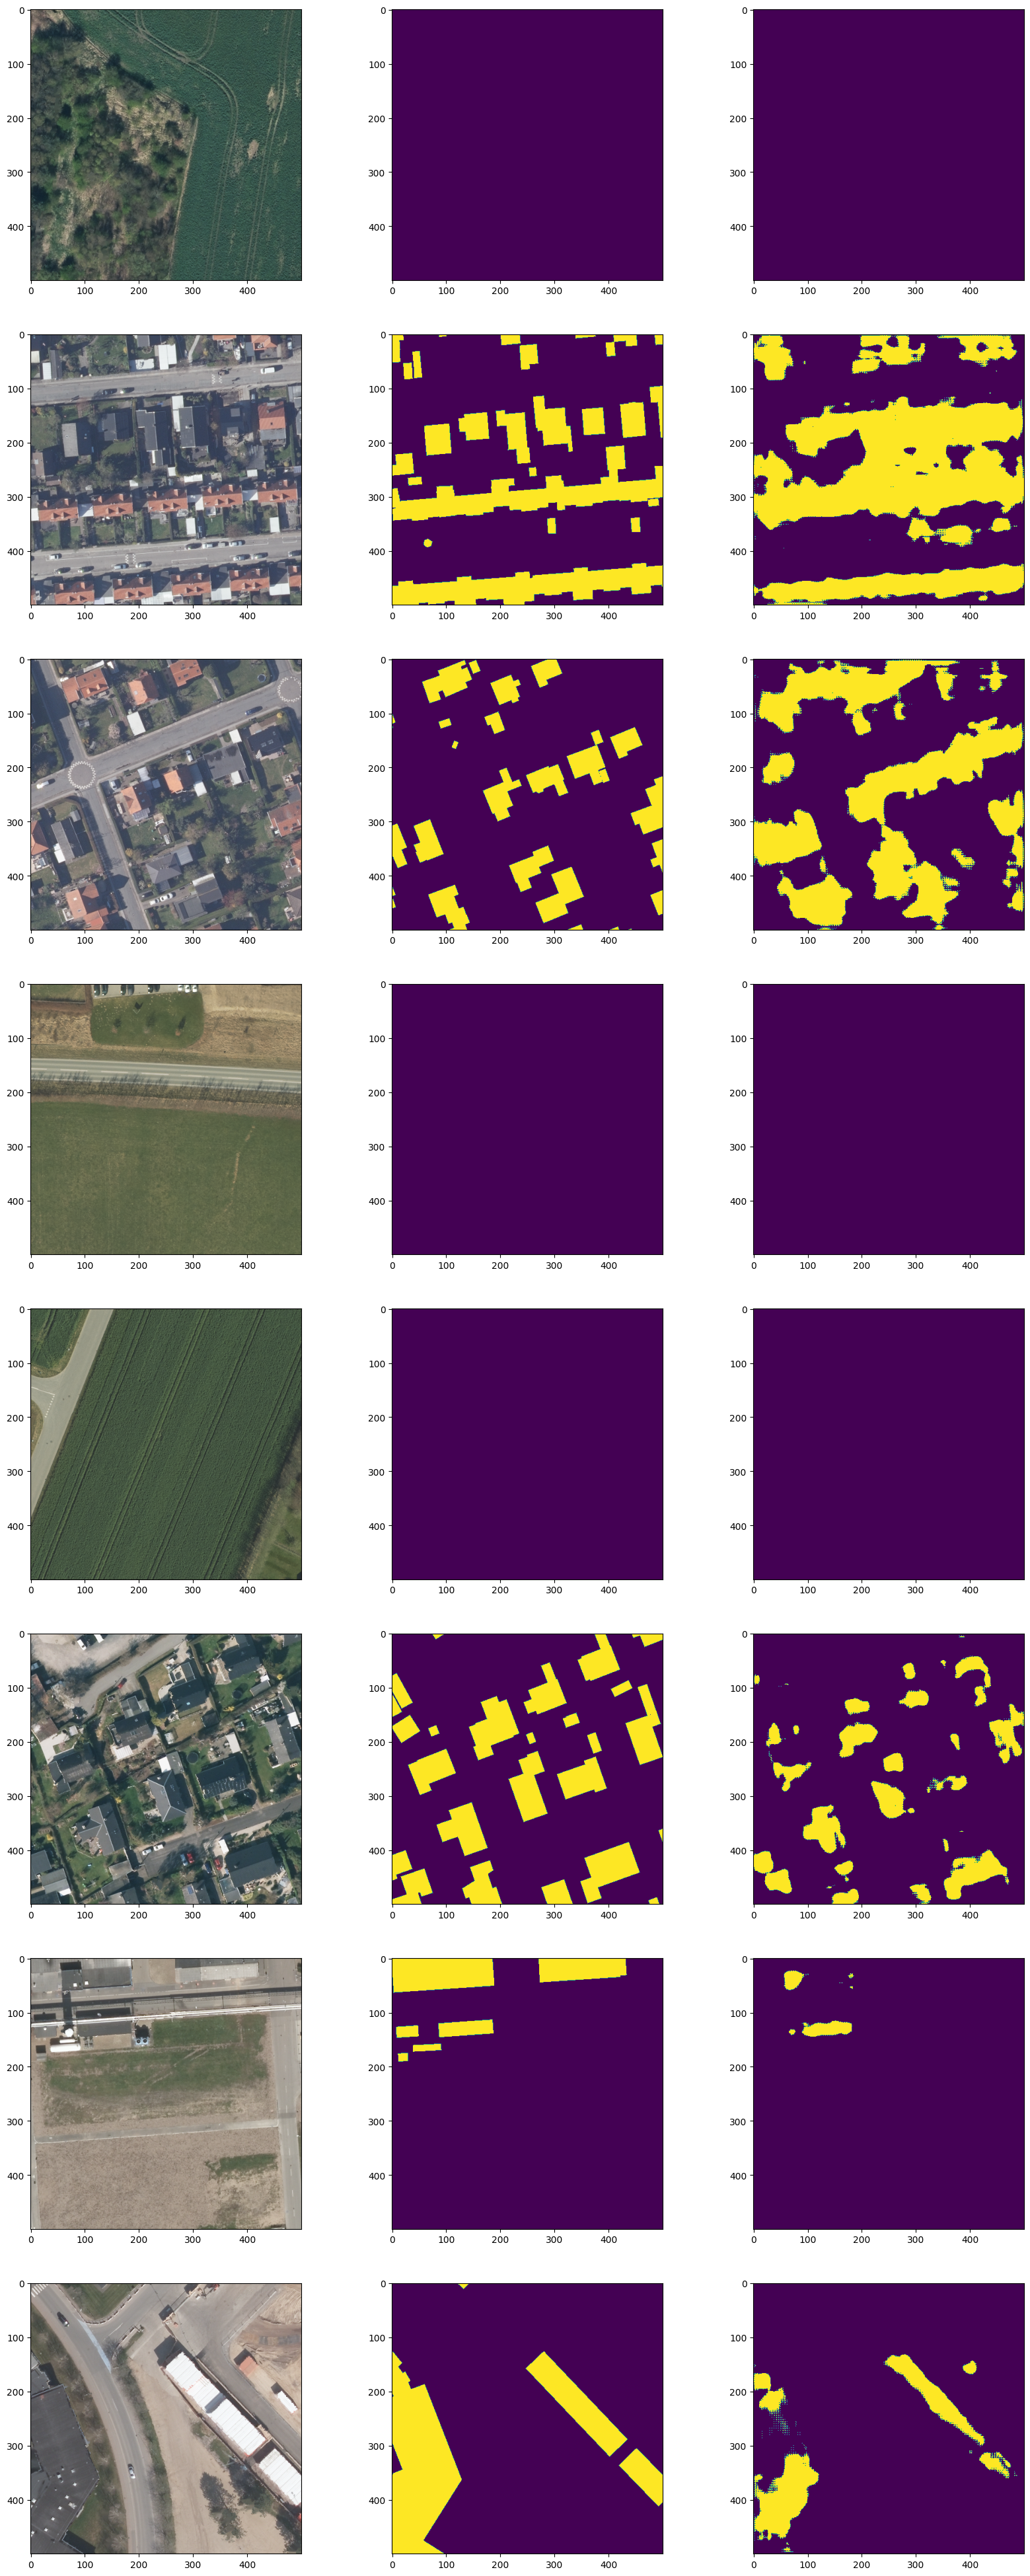

In [4]:
import torch
from model import AutoEncoder
import matplotlib.pyplot as plt
from train import create_dataloader

opts = {
    "epochs":10,
    "lr": 1e-3,
    "config": "config/data.yaml",
    "device": "cpu",
    "task": 1,
    "data_ratio": 1.0,
    "imagesize": 500,
    "task1": {
        "batchsize": 8,
        "shuffle": True
    }
}


trainloader = iter(create_dataloader(opts, "train"))

batch = next(trainloader)
image, label, filename = batch
image = image.to(opts["device"])
label = label.to(opts["device"])
print(image.shape)
print(label.shape)

model = AutoEncoder()
model.load_state_dict(torch.load("./last_task1_9.pt", map_location=torch.device(opts["device"])))
model.eval()


output = model(image)["out"]
output = torch.argmax(torch.softmax(output, dim=1), dim=1).detach()

numberOfSamples = len(image)
fig, ax = plt.subplots(numberOfSamples, 3)
fig.set_size_inches(20, 50)
for i in range(numberOfSamples):
    img = image[i].permute(1, 2, 0)
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(label[i].float())
    ax[i, 2].imshow(output[i].float())

plt.show()
    